In [1]:
import torch
import numpy as np
import pickle
from lpne.models import DcsfaNmf
from lpne.plotting import circle_plot
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from PIL import Image
import matplotlib.pyplot as plt
import os, sys

umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

flx_data_path = "/work/mk423/Anxiety/all_FLX_{}.pkl"
epm_data_path = "/work/mk423/Anxiety/EPM_{}_dict_May_17.pkl"
oft_data_path = "/work/mk423/Anxiety/OFT_{}_dict_old_features_hand_picked.pkl"

anx_info_dict = "/work/mk423/Anxiety/Anx_Info_Dict.pkl"

saved_model_path = "/hpc/home/mk423/Anxiety/FullDataWork/Models/"
saved_model_name = "all_mt_model.pt"

projection_save_path = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
plots_path = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

feature_list = ["X_psd","X_coh","X_gc"]
old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]
feature_weights = [10,1,1]

RANDOM_STATE = 42

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


### Load FLX Data

In [2]:
with open(flx_data_path.format("train"),"rb") as f:
    train_dict = pickle.load(f)
    
with open(flx_data_path.format("val"),"rb") as f:
    val_dict = pickle.load(f)
    
with open(flx_data_path.format("test"),"rb") as f:
    test_dict = pickle.load(f)
    
flx_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_train = train_dict['y_flx']
flx_y_mouse_train = train_dict['y_mouse']
flx_y_hab_train = train_dict['y_hab']
flx_y_time_train = train_dict['y_time']

flx_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_val = val_dict['y_flx']
flx_y_mouse_val = val_dict['y_mouse']
flx_y_hab_val = val_dict['y_hab']
flx_y_time_val = val_dict['y_time']

flx_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(feature_list,feature_weights)])
flx_y_test = test_dict['y_flx']
flx_y_mouse_test = test_dict['y_mouse']
flx_y_hab_test = test_dict['y_hab']
flx_y_time_test = test_dict['y_time']


### Load OFT Data

In [3]:
with open(oft_data_path.format("train"),'rb') as f:
    train_dict = pickle.load(f)

with open(oft_data_path.format("validation"),'rb') as f:
    val_dict = pickle.load(f)
    
with open(oft_data_path.format("test"),'rb') as f:
    test_dict = pickle.load(f)
    

running_idx = 0
feature_groups = []
for idx,feature in enumerate(old_feature_list):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

NUM_FREQS = 56
NUM_FEATURES = np.hstack([train_dict[feature] for feature in old_feature_list]).shape[1] // NUM_FREQS
scale_vector = np.array([np.arange(1,NUM_FREQS+1) for feature in range(NUM_FEATURES)]).flatten()

#Train Arrays
oft_X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_train = train_dict['y_Homecage'].astype(bool)
oft_y_task_train = ~oft_y_hc_train
oft_y_ROI_train = train_dict['y_ROI']
oft_y_vel_train = train_dict['y_vel']
oft_y_mouse_train = train_dict['y_mouse']
oft_y_time_train = train_dict['y_time']

#Validation Arrays
oft_X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_val = val_dict['y_Homecage'].astype(bool)
oft_y_task_val = ~oft_y_hc_val
oft_y_ROI_val = val_dict['y_ROI']
oft_y_vel_val = val_dict['y_vel']
oft_y_mouse_val = val_dict['y_mouse']
oft_y_time_val = val_dict['y_time']

#Test Arrays
oft_X_test = np.hstack([test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
oft_y_hc_test = test_dict['y_Homecage'].astype(bool)
oft_y_task_test = ~oft_y_hc_test
oft_y_ROI_test = test_dict['y_ROI']
oft_y_vel_test = test_dict['y_vel']
oft_y_mouse_test = test_dict['y_mouse']
oft_y_time_test = test_dict['y_time']

oft_X = np.vstack([oft_X_train,oft_X_val])
oft_y_task = np.hstack([oft_y_task_train,oft_y_task_val])
oft_y_mouse = np.hstack([oft_y_mouse_train,oft_y_mouse_val])

### Load EPM Data

In [4]:
with open(epm_data_path.format("train"),"rb") as f:
    epm_train_dict = pickle.load(f)

with open(epm_data_path.format("val"),"rb") as f:
    epm_validation_dict = pickle.load(f)
    
with open(epm_data_path.format("test"),"rb") as f:
    epm_test_dict = pickle.load(f)

#Load the data
NUM_FREQS = 56
NUM_FEATURES = (epm_train_dict["X_power_1_2"].shape[1] + \
                epm_train_dict["X_coh_1_2"].shape[1] + \
                epm_train_dict["X_gc_1_2"].shape[1]) // NUM_FREQS
SCALE_VECTOR = np.array([np.arange(1,57) for feature in range(NUM_FEATURES)]).flatten()

X_train = np.hstack([epm_train_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
X_train[X_train<0] = 0
y_train = (epm_train_dict['y_ROI']%2).astype(bool)
y_in_task_mask_train = ~epm_train_dict['y_Homecage'].astype(bool)
y_mouse_train = epm_train_dict['y_mouse']
y_time_train = epm_train_dict['y_time']
train_nan_mask = (epm_train_dict['y_ROI'] > 0)


X_train_task = X_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_train_task = y_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_mouse_train_task = y_mouse_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
y_time_train_task = y_time_train[np.logical_and(y_in_task_mask_train==1,train_nan_mask)==1]
X_val = np.hstack([epm_validation_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])


y_val = (epm_validation_dict['y_ROI']%2).astype(bool)
y_in_task_mask_val= ~epm_validation_dict['y_Homecage'].astype(bool)
y_mouse_val = epm_validation_dict['y_mouse']
y_time_val = epm_validation_dict['y_time']
val_nan_mask = (epm_validation_dict['y_ROI'] > 0)

X_val_task = X_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_val_task = y_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_mouse_val_task = y_mouse_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]
y_time_val_task = y_time_val[np.logical_and(y_in_task_mask_val==1,val_nan_mask)==1]

X_test = np.hstack([epm_test_dict[feature]*weight for feature,weight in zip(old_feature_list,feature_weights)])
y_test = (epm_test_dict['y_ROI']%2).astype(bool)
y_in_task_mask_test= ~epm_test_dict['y_Homecage'].astype(bool)
y_mouse_test = epm_test_dict['y_mouse']
y_time_test = epm_test_dict['y_time']
test_nan_mask = (epm_test_dict['y_ROI'] > 0)

X_test_task = X_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_test_task = y_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_mouse_test_task = y_mouse_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]
y_time_test_task = y_time_test[np.logical_and(y_in_task_mask_test==1,test_nan_mask)==1]

epm_X = np.vstack([X_train_task,X_val_task])
epm_y_task = np.hstack([y_train_task,y_val_task])
epm_y_mouse = np.hstack([y_mouse_train_task,y_mouse_val_task])
epm_y_time = np.hstack([y_time_train_task,y_time_val_task])


### Concatenate Experiment Data

In [5]:
mt_X_train = np.vstack([flx_X_train[flx_y_hab_train==1],oft_X_train,X_train])
mt_y_train = np.hstack([flx_y_train[flx_y_hab_train==1],oft_y_task_train,y_in_task_mask_train]).reshape(-1,1)
mt_y_mouse_train = np.hstack([flx_y_mouse_train[flx_y_hab_train==1],oft_y_mouse_train,y_mouse_train])

mt_X_val = np.vstack([flx_X_val[flx_y_hab_val==1],oft_X_val,X_val])
mt_y_val = np.hstack([flx_y_val[flx_y_hab_val==1],oft_y_task_val,y_in_task_mask_val]).reshape(-1,1)
mt_y_mouse_val = np.hstack([flx_y_mouse_val[flx_y_hab_val==1],oft_y_mouse_val,y_mouse_val])

mt_X_test = np.vstack([flx_X_test[flx_y_hab_test==1],oft_X_test,X_test])
mt_y_test = np.hstack([flx_y_test[flx_y_hab_test==1],oft_y_task_test,y_in_task_mask_test]).reshape(-1,1)
mt_y_mouse_test = np.hstack([flx_y_mouse_test[flx_y_hab_test==1],oft_y_mouse_test,y_mouse_test])

intercept_mask = OneHotEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1)).todense()
sample_groups = OrdinalEncoder().fit_transform(mt_y_mouse_train.reshape(-1,1))

### Train the Model

In [6]:
TRAIN = False

if TRAIN:
    model = DcsfaNmf(
        n_components=20,
        n_intercepts=intercept_mask.shape[1],
        optim_name="SGD",
        recon_loss="MSE",
        feature_groups=feature_groups,
        fixed_corr=["positive"],
        save_folder=saved_model_path,
    )

    model.fit(mt_X_train,
              mt_y_train,
              intercept_mask=intercept_mask,
              y_sample_groups=sample_groups,
              batch_size=128,
              lr=1e-3,
              n_pre_epochs=1000,
              n_epochs=1000,
              nmf_max_iter=3000,
              pretrain=True,
              verbose=True,
              X_val=mt_X_val,
              y_val=mt_y_val,
              best_model_name=saved_model_name)

    torch.save(model,saved_model_path + saved_model_name)
    
else:
    model = torch.load(saved_model_path + saved_model_name)

### Evaluate Convergence

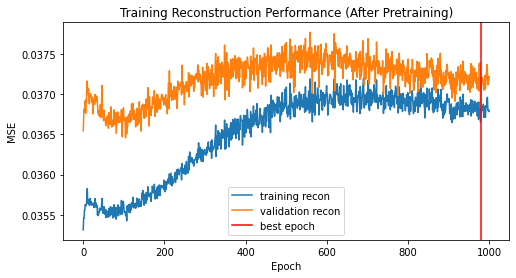

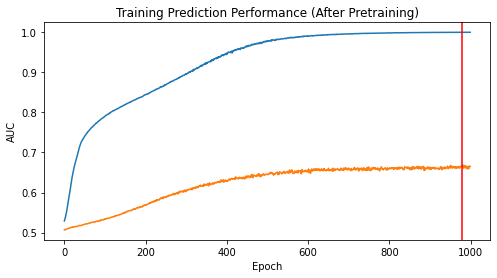

In [7]:
plt.figure(figsize=(8,4))
plt.plot(model.recon_hist,label="training recon")
plt.plot(model.val_recon_hist,label="validation recon")
plt.axvline(model.best_epoch,color="red",label="best epoch")
plt.title("Training Reconstruction Performance (After Pretraining)")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(model.pred_hist,label="training auc")
plt.plot(model.val_pred_hist,label="validation auc")
plt.axvline(model.best_epoch,color="red",label="best epoch")
plt.title("Training Prediction Performance (After Pretraining)")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

### Multitask Performance Evaluation

In [8]:
mt_train_auc = model.score(mt_X_train,mt_y_train)
mt_val_auc = model.score(mt_X_val,mt_y_val)
mt_test_auc = model.score(mt_X_test,mt_y_test)

print("train auc: {}".format(mt_train_auc))
print("val auc: {}".format(mt_val_auc))

train auc: [0.98313621]
val auc: [0.66507521]


### FLX Performance Evaluation

In [9]:
flx_train_auc = model.score(flx_X_train[flx_y_hab_train==1],
                            flx_y_train[flx_y_hab_train==1].reshape(-1,1))

flx_val_auc = model.score(flx_X_val[flx_y_hab_val==1],
                          flx_y_val[flx_y_hab_val==1].reshape(-1,1),
                            flx_y_mouse_val[flx_y_hab_val==1],
                            return_dict=True)

flx_test_auc = model.score(flx_X_test[flx_y_hab_test==1],
                           flx_y_test[flx_y_hab_test==1].reshape(-1,1),
                            flx_y_mouse_test[flx_y_hab_test==1],
                            return_dict=True)

mean_val_auc = np.mean([flx_val_auc[key] for key in flx_val_auc.keys()])
stderr_val_auc = np.std([flx_val_auc[key] for key in flx_val_auc.keys()]) / np.sqrt(len(flx_val_auc.keys()))

print("train auc: {}".format(flx_train_auc))
print("val auc: {:.3f} +/- {:.3f}".format(mean_val_auc,stderr_val_auc))

train auc: [0.96333703]
val auc: 0.632 +/- 0.053


In [28]:
flx_val_auc

{'Mouse3192': [0.6906873651564186],
 'Mouse3193': [0.44936866623517946],
 'Mouse78732': [0.6730329460704887],
 'Mouse78764': [0.7146385041875263]}

### EPM Performance Evaluation

In [10]:
epm_train_auc = model.score(X_train,
                            y_in_task_mask_train.reshape(-1,1),
                            y_mouse_train,
                            return_dict=True)

epm_val_auc = model.score(X_val,
                          y_in_task_mask_val.reshape(-1,1),
                          y_mouse_val,
                          return_dict=True)

epm_test_auc = model.score(X_test,
                           y_in_task_mask_test.reshape(-1,1),
                           y_mouse_test,
                           return_dict=True)

mean_train_auc = np.mean([epm_train_auc[key] for key in epm_train_auc.keys()])
stderr_train_auc = np.std([epm_train_auc[key] for key in epm_train_auc.keys()]) / np.sqrt(len(epm_train_auc.keys()))

mean_val_auc = np.mean([epm_val_auc[key] for key in epm_val_auc.keys()])
stderr_val_auc = np.std([epm_val_auc[key] for key in epm_val_auc.keys()]) / np.sqrt(len(epm_val_auc.keys()))

print("train auc: {:.3f} +/- {:.3f}".format(mean_train_auc,stderr_train_auc))
print("val auc: {:.3f} +/- {:.3f}".format(mean_val_auc,stderr_val_auc))


train auc: 1.000 +/- 0.000
val auc: 0.787 +/- 0.017


### OFT Performance Evaluation

In [11]:
oft_train_auc = model.score(oft_X_train,
                            oft_y_task_train.reshape(-1,1))
                            #oft_y_mouse_train,
                            #return_dict=True)

oft_val_auc = model.score(oft_X_val,
                            oft_y_task_val.reshape(-1,1),
                            oft_y_mouse_val,
                            return_dict=True)

oft_test_auc = model.score(oft_X_test,
                            oft_y_task_test.reshape(-1,1),
                            oft_y_mouse_test,
                            return_dict=True)

#mean_train_auc = np.mean([oft_train_auc[key] for key in oft_train_auc.keys()])
#stderr_train_auc = np.std([oft_train_auc[key] for key in oft_train_auc.keys()]) / np.sqrt(len(oft_train_auc.keys()))

mean_val_auc = np.mean([oft_val_auc[key] for key in oft_val_auc.keys()])
stderr_val_auc = np.std([oft_val_auc[key] for key in oft_val_auc.keys()]) / np.sqrt(len(oft_val_auc.keys()))

#print("train auc: {:.3f} +/- {:.3f}".format(mean_train_auc,stderr_train_auc))
print("train auc: {:.3f}".format(oft_train_auc[0]))
print("val auc: {:.3f} +/- {:.3f}".format(mean_val_auc,stderr_val_auc))

train auc: 0.994
val auc: 0.841 +/- 0.036


### Visualize the Network

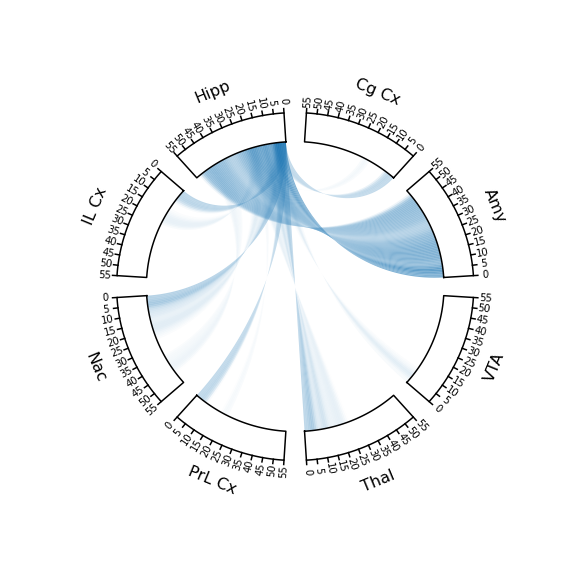

In [32]:
def reshapeData(X_psd,X_coh,n_rois,n_freqs,pow_features,coh_features,areas):
    X_3d = np.zeros((n_rois,n_rois,n_freqs))
    
    for i in range(n_rois):
        X_3d[i,i,:] = X_psd[i*n_freqs:(i+1)*n_freqs]
        
    
    split_coh_features = np.array([feature.split(' ')[0] for feature in coh_features])
    #print(split_coh_features)
    unique_coh_features = np.unique(split_coh_features)
    for i in range(n_rois):
        for j in range(n_rois):
            if i != j:
                area_1 = areas[i]
                area_2 = areas[j]
                temp_feature = area_1 + "-" + area_2
                temp_feature_2 = area_2 + "-" + area_1
                if temp_feature in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature,True,False)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                elif temp_feature_2 in unique_coh_features:
                    feature_mask = np.where(split_coh_features==temp_feature_2,1,0)
                    X_3d[i,j,:] = X_coh[feature_mask==1]
                    X_3d[j,i,:] = X_coh[feature_mask==1]

                else:
                    print("temp_feature: {} not found".format(temp_feature))

    return X_3d

with open("/work/mk423/Anxiety/Anx_Info_Dict.pkl","rb") as f:
    anxInfo = pickle.load(f)
    
s = model.project(mt_X_val)
X_sup_recon = model.get_comp_recon(torch.Tensor(s).to("cuda"),0)
X_recon = model.reconstruct(mt_X_val)

recon_contribution = np.mean(X_sup_recon/X_recon,axis=0)
rec_psd = recon_contribution[:len(anxInfo["powerFeatures"])]
rec_coh = recon_contribution[len(anxInfo["powerFeatures"]):(len(anxInfo["powerFeatures"]) + len(anxInfo["cohFeatures"]))]
rec_3d = reshapeData(rec_psd,rec_coh,8,56,anxInfo["powerFeatures"],anxInfo["cohFeatures"],anxInfo["area"])

circle_plot(rec_3d,anxInfo["area"],freqs=np.arange(56),freq_ticks=np.arange(0,56,5),min_max_quantiles=(0.9,0.9999),fn=plots_path + "notebook_electome.png")
image = Image.open(plots_path + "notebook_electome.png")
image.show()

### Check Upper Triangular Plot

(1, 448) (1, 1568) (1, 3136)


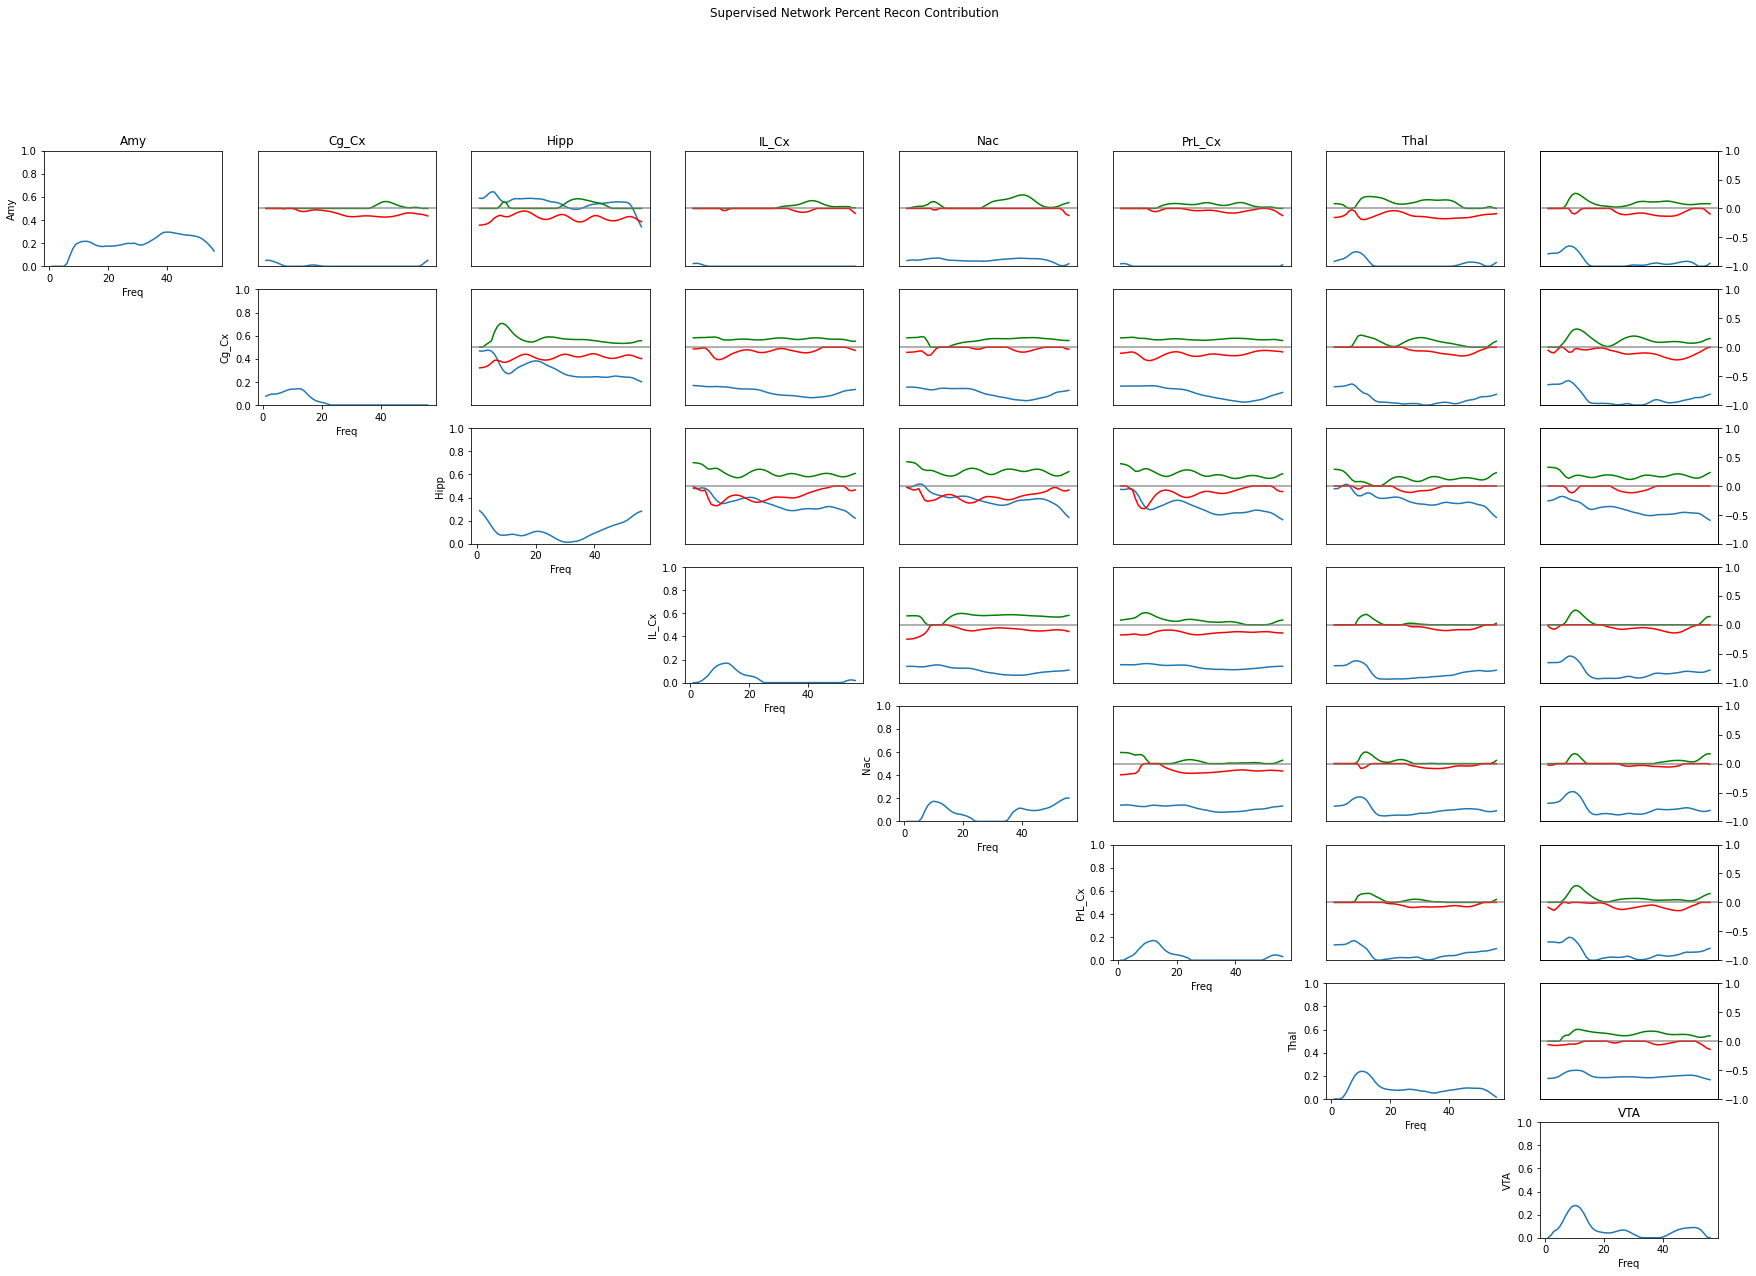

In [16]:
umc_dt.makeUpperTriangularPlot_pow_coh_gc(recon_contribution.reshape(1,-1),anxInfo["area"],anxInfo["powerFeatures"],
                                          anxInfo["cohFeatures"],anxInfo["gcFeatures"],saveFile=plots_path + "upTri-Anx.png")